In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('spotify_data.csv')

In [4]:
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [5]:
def popularity(x):
    if x['popularity'] > 70:
        return 1
    else:
        return 0

In [8]:
df['popular'] = df.apply(popularity, axis = 1)

## **Logistic Regression Model**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [73]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [74]:
y = df['popular']

In [75]:
X = df.drop(['popular', 'popularity'], axis = 1)

In [76]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

In [77]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [78]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=0.1,
        solver='saga',
        class_weight='balanced',
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [85]:
clf = logreg_pipeline.fit(X_train, y_train)

In [89]:
y_pred_lg = clf.predict(X_test)

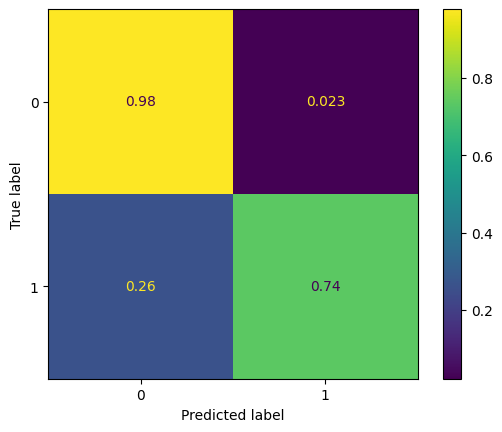

In [90]:
cm = confusion_matrix(y_test, y_pred_lg, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [7]:
def model_quality_class(y_true, y_pred, average='binary'):
    print('Accuracy =', accuracy_score(y_true, y_pred))
    print('Precision =', precision_score(y_true, y_pred, zero_division=0, average=average))
    print('Recall =', recall_score(y_true, y_pred, average=average))
    print('F1 =', f1_score(y_true, y_pred, average=average))

In [20]:
model_quality_class(y_test, y_pred_lg)

Accuracy = 0.9768616918082542
Precision = 0.07501330023053733
Recall = 0.7369337979094077
F1 = 0.1361661033317238


In [21]:
probs = logreg_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_value = roc_auc_score(y_test, probs)
print(f"ROC AUC = {auc_value:.3f}")


ROC AUC = 0.973


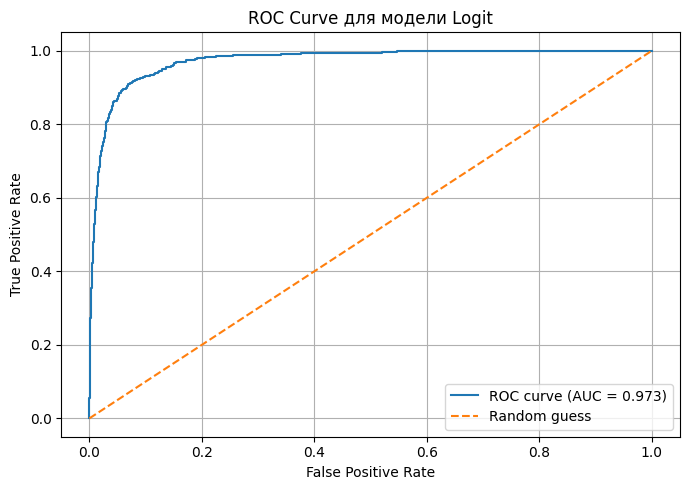

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для модели Logit')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Логистическая регрессия на аудио-признаках показывает парадоксальный, но объяснимый набор метрик: accuracy почти 0,98 обманчиво высока из-за дисбаланса классов, precision всего 7,5 % предупреждает о дорогих ложноположительных решениях, тогда как recall 0,74 и ROC-AUC 0,97 доказывают, что модель великолепно ранжирует треки и почти не упускает настоящие хиты, если использовать её именно как приоритизатор. Это сочетание открывает три взаимодополняющих бизнес-направления.

Во-первых, оптимизация маркетингового бюджета: прогноз «вероятности хита» позволяет маркетинговой команде выставлять градации приоритета — от агрессивного продвижения с инфлюенсерами и платным плейсментом до минимального упоминания в соцсетях. Благодаря высокой ранжирующей способности модели можно гибко двигать порог: для дорогих каналов (TV, билборды) выбрать верхние 1–2 % треков, добиваясь precision, приемлемой для крупных затрат, а для более дешёвых digital-активаций расширять окно до 5–10 %, сохраняя высокий recall. В итоге меньше средств уходит «в никуда», а ROI кампаний растёт.

Во-вторых, поиск новых артистов и работа с лейблами (talent scouting). Здесь ценен именно высокий recall: сервис, фильтрует тысячи демо-заявок и выносит наверх 20–30 треков с максимальным Hit-Score, среди которых почти три четверти будущих хитов уже присутствуют. Лейбл получает возможность подписать малоизвестного исполнителя на эксклюзивных условиях до того, как конкуренты разглядят потенциал, а артист взамен получает продюсерскую и маркетинговую поддержку. Низкая precision не критична: прослушивание shortlist стоит лишь времени A&R-команды, тогда как пропуск молодого «бриллианта» обернётся упущенными правами и будущим стриминговым доходом.

Наконец, рост вовлечённости и удержания пользователей на стриминговой платформе. В плейлистах-рекомендациях и разделе «Тренды» можно алгоритмически повышать ранжирование треков с высокой вероятностью хита, ускоряя их попадание в уши слушателей. Для фронт-энда это выглядит как более своевременное появление «песен-крючков», что увеличивает количество прослушиваний на пользователя, снижает churn и поднимает LTV. Ошибочный пуш «не-хита» в ленту не столь опасен — пользователь просто переключит трек, тогда как раннее появление настоящего хита формирует эмоциональную привязанность к сервису («здесь музыка открывается раньше»).

Таким образом, одна и та же модель, правильно интерпретированная, даёт трёхуровневую пользу: экономит бюджет, приносит эксклюзивный контент через ранние контракты и усиливает пользовательскую лояльность за счёт более точных рекомендаций. Ключевой принцип — не превращать бинарный вывод модели в окончательный вердикт, а использовать её ранговый потенциал там, где каждая сторона (маркетолог, A&R-специалист, рекомендательная система) способна добавить человеческую экспертизу и минимизировать стоимость ошибки.

## **Decision trees**

In [27]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [9]:
X = df.drop(['popular', 'popularity'], axis=1)
y = df['popular']

In [ ]:
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500,
        max_depth=100,
        class_weight='balanced',
        max_features='sqrt',
        max_samples=0.8,
        n_jobs=-1,
        random_state=42
    ))
])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [40]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

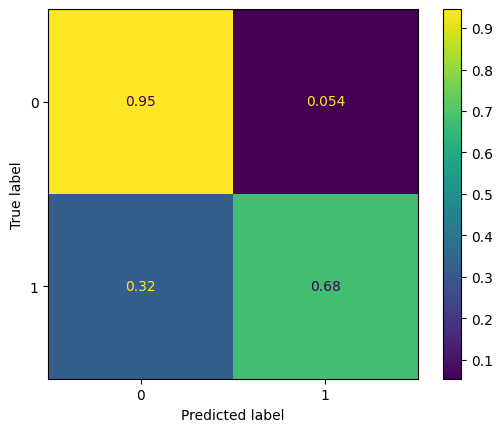

In [41]:
cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [ ]:
model_quality_class(y_test, y_pred_rf)

Accuracy = 0.9450276564648873
Precision = 0.031018518518518518
Recall = 0.6756302521008404
F1 = 0.059313906307635555


In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.pipeline import Pipeline  

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__missing__')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,     numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [59]:
gb_pipeline = Pipeline([
    ('pre',   preprocessor),
    ('smote', SMOTE(random_state=42, n_jobs=-1)),
    ('clf',   HistGradientBoostingClassifier(
        max_iter=500,
        learning_rate=0.01,
        max_depth=50,
        class_weight='balanced',
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42
    ))
])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [61]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'year',
                                                   'danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature']),
                                                 ('cat',
                                                  Pipeline(ste...
                                                                   SimpleImputer(fill_value='__missing__',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['artist_name', 'track_name',
                                                   'track_id', 'genre'])])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                learning_rate=0.01,
                                                max_depth=50, max_iter=500,
                                                random_state=42))])

In [63]:
y_pred_gb = gb_pipeline.predict(X_test)

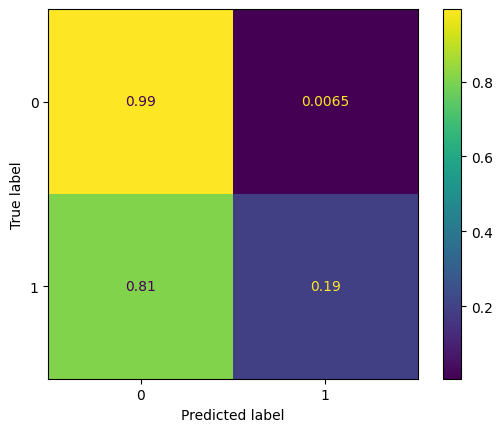

In [64]:
cm = confusion_matrix(y_test, y_pred_gb, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [25]:
model_quality_class(y_test, y_pred_gb)

Accuracy = 0.9968140097347308
Precision = 0.19557195571955718
Recall = 0.09233449477351917
F1 = 0.12544378698224853


Для моделей деревьев не получилось получить метрики лучше, чем в логистической регрессии, поэтому все интерпритация для логистической регрессии